### Nous présentons ici les approches finales de classification pour la deuxième phase du stage après plusieurs expérimentations 

### 1. Les données

Nous avons formé les données en utilisant les sources de padi-web (VS en SV), ESV, ESA ainsi que les articles nettoyés de la phase 1 du stage (ceux dans lequels on avait supprimé les noms de maladie, les liens hypertextes, détecté la langue)

### 2. Prétaitement 

Sur ces données collectées et rassemblées dans le fichier *data_final_phase2_private.csv*, nous avons appliqué un nettoyage des textes pour former la colonne *text_clean*, que nous utilisons pour la classification. Nous avons appliqué la suppression des stopword, la lemmatisation, la suppression des caractères incompréhensibles en anglais, la mise en minuscule 

### 3. Classification 

Nous avons testé plusieurs approches à l'instar de: 
- Vectorisation avec TF-IDF et puis classification avec Naive Bayes 
- Vectorisation avec TF-IDF et puis classification avec la Regression Logistique 
- Vectorisation avec SBERT et puis classification avec la Regression Logistique
- Vectorisation avec SBERT et puis classification avec MLP de PyTorch 
- Vectorisation avec SBERT et puis classification avec XGBOOST
- Vectorisation avec TF-IDF et puis classification avec XGBOOST : marche mieux que les approches précédentes mais reste limité lors de l'usage des mots synomyms 
- Fine-tuning de SBERT : marche très bien 
- Fine-tuning de RoBERTa : en cours car prend énormément de temps 

### 4. Ce que nous présentons ici sont les 3 dernières approches 

Pour commencer nous définition la fonction utilitaire de nettoyage que nous avons appliqué pour former les données nettoyés, nous utilisons les données nettoyées pour TF-IDF + XGBOOST, donc nous allons utiliser cette fonction pour nettoyer les phrases lorsqu'on fera le test.

Pour le fine-tuning de SBERT, nous n'allons pas relancer l'entrainement mais juste faire les tests dans la suite avec les textes brutes (en utilisant le modèle sauvegardé), car nous avons entrainé avec ce modèle sur les textes brutes (recommandé de faire).

Pour le fine-tuning de RoBERTa nous laisserons le script tout simplement afin car l'entrainement prend énormément de temps (le faire avec un GPU)

### Fonction utilitaire de nettoyage des textes 

In [1]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation

# Initialisation
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
custom_stopwords = {'et', 'al'} # Les expressions que nous avons retrouvé en grande quantité lors de nos expérimentations et nous avons décidé de ne pas les conserver 


def nettoyer_texte(texte):
    """
    Nettoie un texte brut :
    2. Tokenisation
    3. Nettoyage caractères spéciaux
    4. Suppression stopwords, ponctuation, custom_stopwords
    5. Lemmatisation
    """
    
    # Étape 2 : tokenisation
    tokens = word_tokenize(texte)

    # Étape 3-6 : nettoyage
    tokens_nettoyes = []
    for token in tokens:
        token = token.lower()
        token = re.sub(r'\s+', '', token)
        token = re.sub(r'[^a-zàâçéèêëîïôûùüÿñæœ]', '', token)

        if (
            token
            and token not in stop_words
            and token not in punctuation
            and token not in custom_stopwords
        ):
            token = lemmatizer.lemmatize(token)
            tokens_nettoyes.append(token)

    return ' '.join(tokens_nettoyes)


### TF-IDF + XGBOOST

Nous avons utilisé les index sauvegardés pour faire une sélection reproductible des ensembles d'entrainement, de validation et de test 

In [3]:
import pandas as pd 

data = pd.read_csv("./data/data_final_phase2_private.csv", keep_default_na=False)

[0]	train-logloss:0.29589	eval-logloss:0.29890
[1]	train-logloss:0.27148	eval-logloss:0.27545
[2]	train-logloss:0.25265	eval-logloss:0.25953
[3]	train-logloss:0.23572	eval-logloss:0.24434
[4]	train-logloss:0.22112	eval-logloss:0.23101
[5]	train-logloss:0.21010	eval-logloss:0.22005
[6]	train-logloss:0.19758	eval-logloss:0.20809
[7]	train-logloss:0.19030	eval-logloss:0.20184
[8]	train-logloss:0.18035	eval-logloss:0.19291
[9]	train-logloss:0.17188	eval-logloss:0.18514
[10]	train-logloss:0.16378	eval-logloss:0.17734
[11]	train-logloss:0.15611	eval-logloss:0.16951
[12]	train-logloss:0.14924	eval-logloss:0.16346
[13]	train-logloss:0.14300	eval-logloss:0.15773
[14]	train-logloss:0.13729	eval-logloss:0.15265
[15]	train-logloss:0.13150	eval-logloss:0.14775
[16]	train-logloss:0.12647	eval-logloss:0.14297
[17]	train-logloss:0.12108	eval-logloss:0.13787
[18]	train-logloss:0.11656	eval-logloss:0.13414
[19]	train-logloss:0.11265	eval-logloss:0.13025
[20]	train-logloss:0.10847	eval-logloss:0.12656
[2

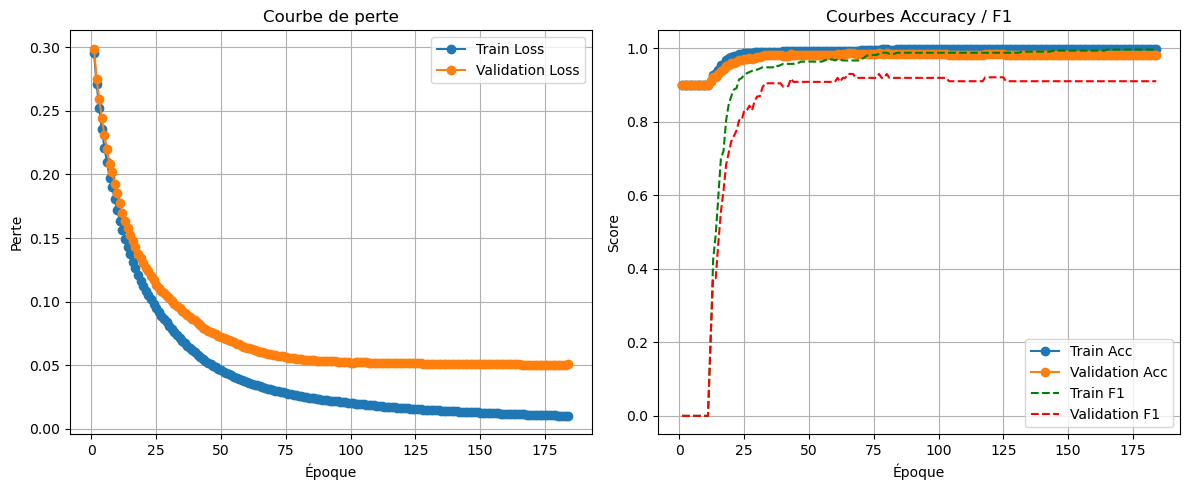

=== Rapport de classification (TF-IDF + XGBoost) sur les données de test ===
              precision    recall  f1-score   support

         NVS       0.99      1.00      0.99       202
          VS       1.00      0.87      0.93        23

    accuracy                           0.99       225
   macro avg       0.99      0.93      0.96       225
weighted avg       0.99      0.99      0.99       225



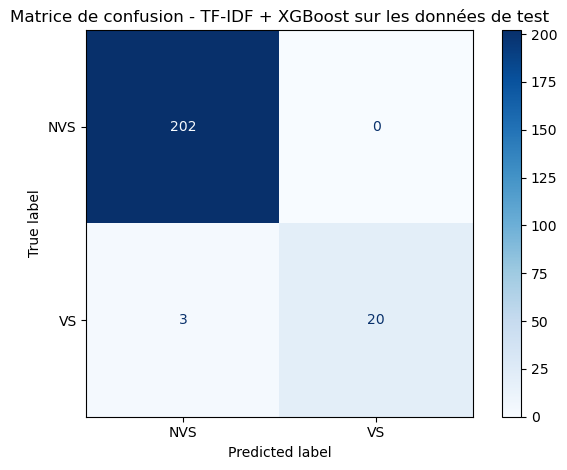

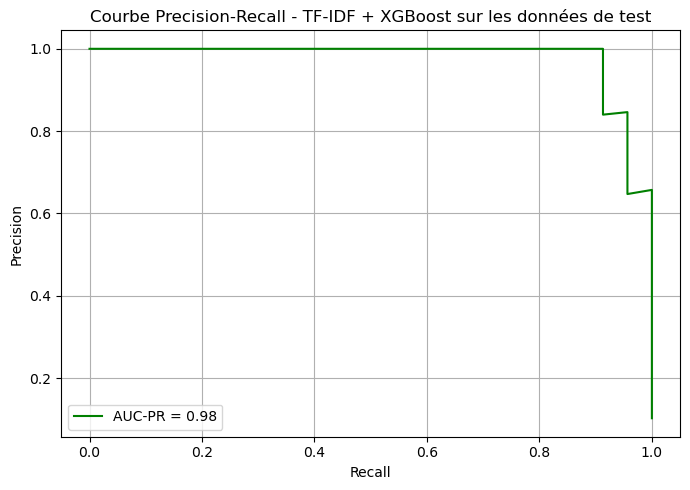

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    average_precision_score
)
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from sklearn.metrics import accuracy_score, f1_score
import os, joblib
import numpy as np

idx_train = np.load("splits_idx_train.npy")
idx_val   = np.load("splits_idx_val.npy")
idx_test  = np.load("splits_idx_test.npy")

# === 1. Données
X = data["text_clean"].astype(str).to_numpy()
y = data["type_article"].to_numpy()

# Encodage binaire (NVS = 0, VS = 1)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# === 2. Split train / temp
X_train_texts, X_val_texts, X_test_texts = X[idx_train], X[idx_val], X[idx_test]
y_train, y_val, y_test = y_enc[idx_train], y_enc[idx_val], y_enc[idx_test]



# === 4. TF-IDF Vectorisation
vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vec.fit_transform(X_train_texts)
X_val_vec   = vec.transform(X_val_texts)
X_test_vec  = vec.transform(X_test_texts)

# === 5. Modèle XGBoost avec early stopping


# Convertir en DMatrix, forme optimisée pour le modèle xgboost
dtrain = xgb.DMatrix(X_train_vec, label=y_train)
dval = xgb.DMatrix(X_val_vec, label=y_val)
dtest = xgb.DMatrix(X_test_vec)

# Paramètres du modèle
params = {
    "objective": "binary:logistic", # classification binaire
    "eval_metric": "logloss", # on regarde le logarithme de l'erreur 
    "max_depth": 5, # profondeur d'un arbre de la forêt
    "eta": 0.05, # taux d'apprentissage
    "subsample": 0.8, # taux d'échantillonnage 
    "colsample_bytree": 0.8,
    "seed": 42
}

# Initialisation du dictionnaire pour stocker les métriques
evals_result = {}

# Entraînement avec early stopping
watchlist = [(dtrain, "train"), (dval, "eval")]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000, # les arbres sont ajoutés de manière itérative, maintenant si l'apprentissage n'évolue pas on ajoute plus d'arbre
    evals=watchlist,
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=True
)

# === Courbes d'apprentissage (loss, accuracy, f1) ===
train_loss = evals_result['train']['logloss']
val_loss = evals_result['eval']['logloss']

# On calcule manuellement accuracy et f1 à chaque étape
train_acc, val_acc, train_f1, val_f1 = [], [], [], []

for i in range(len(train_loss)):
    # Prédictions train et val à l'itération i
    y_train_pred = (bst.predict(dtrain, iteration_range=(0, i+1)) >= 0.5).astype(int)
    y_val_pred = (bst.predict(dval, iteration_range=(0, i+1)) >= 0.5).astype(int)

    # Accuracies
    train_acc.append(accuracy_score(y_train, y_train_pred))
    val_acc.append(accuracy_score(y_val, y_val_pred))

    # F1 scores
    train_f1.append(f1_score(y_train, y_train_pred))
    val_f1.append(f1_score(y_val, y_val_pred))


# Affichage des courbes 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# --- Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.title("Courbe de perte")
plt.legend()
plt.grid(True)

# --- Courbes Accuracy et F1
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label="Train Acc", marker="o")
plt.plot(epochs, val_acc, label="Validation Acc", marker="o")
plt.plot(epochs, train_f1, label="Train F1", linestyle="--", color="green")
plt.plot(epochs, val_f1, label="Validation F1", linestyle="--", color="red")
plt.xlabel("Époque")
plt.ylabel("Score")
plt.title("Courbes Accuracy / F1")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Prédiction sur les données de test
y_scores = bst.predict(dtest)
y_pred = (y_scores >= 0.5).astype(int)


os.makedirs("models", exist_ok=True)  # crée le dossier si absent

bst.save_model("models/sbert_xgb.json")  # ou best_modele_melange.json si tu veux
joblib.dump(le, "models/label_encoder.pkl")


# Sauvegarde du modèle 
bst.save_model("models/best_tfidf_xgboost.json")

# Sauvegarde du vectorizer 

joblib.dump(vec, "models/vectorizer_tfidf.pkl")

# Rapport
print("=== Rapport de classification (TF-IDF + XGBoost) sur les données de test ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - TF-IDF + XGBoost sur les données de test")
plt.tight_layout()
plt.show()

# Courbe AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = average_precision_score(y_test, y_scores)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.2f}", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Courbe Precision-Recall - TF-IDF + XGBoost sur les données de test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Commentaire

La matrice de confusion montre que les articles de type NVS sont toujours très facilement détectés par ce modèle et se trompe très rarement pour les articles de type VS. Ces performances sont expliqués au travers du score AUC-PR que nous observons sur la courbe. 

#### Détectons les expressions qui permettent à ce modèle de classer un article comme VS, nous allons nous servir des poids TF-IDF 

In [5]:
# Récupérer les scores d'importance des features (TF-IDF)
importance_scores = bst.get_score(importance_type='weight')  # ou 'gain' pour l'impact moyen sur la perte

# Map features index to their names
feature_names = vec.get_feature_names_out()

# Convertir les clés de type 'f123' -> index entier
feature_importances = {
    feature_names[int(k[1:])]: v for k, v in importance_scores.items()
}

# Trier par importance décroissante
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Afficher les 20 mots les plus importants
print("Top 20 mots les plus influents (poids) :")
for word, score in sorted_features[:20]:
    print(f"{word} : {score}")


Top 20 mots les plus influents (poids) :
disease : 118.0
mysterious : 107.0
unknown : 71.0
mystery : 52.0
said : 30.0
block : 29.0
could : 28.0
may : 26.0
new : 25.0
also : 22.0
target : 22.0
found : 17.0
using : 17.0
group : 16.0
illness : 16.0
need : 15.0
reported : 15.0
risk : 14.0
certain : 13.0
pest : 13.0


### Appliquons les tests maintenant avec les phrases qui utilisent ces expressions, des synonyms, et aucun de ces mots pour voir comment ce modèle s'en sort

In [8]:
# === Charger modèle, vectorizer et label encoder ===
bst = xgb.Booster()
bst.load_model("models/best_tfidf_xgboost.json")

vec = joblib.load("models/vectorizer_tfidf.pkl")
le  = joblib.load("models/label_encoder.pkl")

# === Phrases à tester ===
phrases = [
    "Authorities reported an outbreak of a mysterious disease affecting cattle, with new cases detected in nearby farms.",
    "Veterinarians notified the ministry about a cluster of unexplained illness in goats; several more cases were found during inspections.",
    "A national program was launched to improve cattle breeding and milk production, with training provided to local farmers.",
    "Researchers developed a new irrigation system to increase rice yields and reduce water usage in agricultural fields."
]

# === Nettoyage identique à l'entraînement ===
phrases_clean = [nettoyer_texte(p) for p in phrases]

# === Vectorisation ===
X_vec = vec.transform(phrases_clean)

# === Prédictions ===
dmat = xgb.DMatrix(X_vec)
y_scores = bst.predict(dmat)
y_pred = (y_scores >= 0.5).astype(int)
y_labels = le.inverse_transform(y_pred)

# === Affichage ===
for i, p in enumerate(phrases):
    print(f"\nTexte: {p}")
    print(f"Texte nettoyé: {phrases_clean[i]}")
    print(f"-> Classe prédite: {y_labels[i]}")
    print(f"-> Score VS: {y_scores[i]:.4f}, NVS: {1 - y_scores[i]:.4f}")



Texte: Authorities reported an outbreak of a mysterious disease affecting cattle, with new cases detected in nearby farms.
Texte nettoyé: authority reported outbreak mysterious disease affecting cattle new case detected nearby farm
-> Classe prédite: VS
-> Score VS: 0.9841, NVS: 0.0159

Texte: Veterinarians notified the ministry about a cluster of unexplained illness in goats; several more cases were found during inspections.
Texte nettoyé: veterinarian notified ministry cluster unexplained illness goat several case found inspection
-> Classe prédite: NVS
-> Score VS: 0.0042, NVS: 0.9958

Texte: A national program was launched to improve cattle breeding and milk production, with training provided to local farmers.
Texte nettoyé: national program launched improve cattle breeding milk production training provided local farmer
-> Classe prédite: NVS
-> Score VS: 0.0009, NVS: 0.9991

Texte: Researchers developed a new irrigation system to increase rice yields and reduce water usage in agr

### Commentaire: 

Nous constatons que pour la deuxième phrase qui parle bien de veille syndromique (avec les synomyms), le modèle n'arrive pas à trancher proprement entre les deux classes et dit qu'il s'agit d'un article de type NVS. C'est la raison pour laquelle ce modèle ne peut pas être accepté à 100% mais reste utile si jamais on veut avoir un résultat très rapdement et aussi détecter uniquement les NVS  

### Fine-tuning de SBERT 

Nous avons juste remis le script de nos expérimentations, nous n'avons plus entrainé ici, nous allons utiliser le résultat du meilleur modèle obtenu après le fine-tuning pour faire les tests avec les même phrases que nous avons utilisé pour le modèle précédent 

In [ ]:
# =========================
# 0) Imports
# =========================
import os, json, joblib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score, accuracy_score
)

from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, TrainerCallback
)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# =========================
# 1) Données + indices sauvegardés
# =========================
idx_train = np.load("splits_idx_train.npy")
idx_val   = np.load("splits_idx_val.npy")
idx_test  = np.load("splits_idx_test.npy")

X_all = data["text"].astype(str).to_numpy() # Nous lançons l'entrainnement sur les données brutes 
y_all = data["type_article"].to_numpy()

# Encodage labels
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y_all)
num_classes = len(label_encoder.classes_)
print("Classes:", list(label_encoder.classes_))

# Splits
X_train, X_val, X_test = X_all[idx_train], X_all[idx_val], X_all[idx_test]
y_train, y_val, y_test = y_enc[idx_train], y_enc[idx_val], y_enc[idx_test]

# =========================
# 2) Tokenizer & modèle
# =========================
model_name = "sentence-transformers/all-MiniLM-L6-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# =========================
# 3) Dataset PyTorch (robuste)
# =========================
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()
        self.texts = [
            "" if (t is None or (isinstance(t, float) and np.isnan(t))) else str(t)
            for t in texts
        ]
        self.encodings = tokenizer(self.texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels.tolist() if isinstance(labels, np.ndarray) else list(labels)
        assert len(self.texts) == len(self.labels)

    def __len__(self): 
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TextDataset(X_train, y_train, tokenizer)
val_ds   = TextDataset(X_val,   y_val,   tokenizer)
test_ds  = TextDataset(X_test,  y_test,  tokenizer)

# =========================
# 4) Metrics + Callback TrainEval
# =========================
def compute_metrics(eval_pred):
    # Compat: EvalPrediction (HF récent) ou tuple (anciens)
    if hasattr(eval_pred, "predictions"):
        logits = eval_pred.predictions
        labels = eval_pred.label_ids
    else:
        logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

from transformers import TrainerCallback
import math, os

class ValEvalAndEarlyStopCallback(TrainerCallback):
    """
    - Évalue sur le set de validation à la fin de chaque epoch
    - Loggue les métriques 'eval_*' dans log_history
    - Early stopping custom basé sur training_args.metric_for_best_model et greater_is_better
    - Sauvegarde le meilleur modèle dans output_dir/best_checkpoint
    """
    def __init__(self, trainer, patience=3):
        self.trainer = trainer
        self.patience = patience
        self.best_metric = None
        self.best_epoch = None
        self.bad_epochs = 0
        self.best_dir = os.path.join(str(trainer.args.output_dir), "best_checkpoint")
        os.makedirs(self.best_dir, exist_ok=True)

        # lit la config d'arrêt
        self.metric_name = trainer.args.metric_for_best_model or "eval_loss"
        self.greater_is_better = bool(trainer.args.greater_is_better)

    def _is_better(self, current, best):
        if best is None:
            return True
        return (current > best) if self.greater_is_better else (current < best)

    def on_epoch_end(self, args, state, control, **kwargs):
        # 1) Évaluer VAL
        try:
            metrics = self.trainer.evaluate(
                eval_dataset=self.trainer.eval_dataset,
                metric_key_prefix="eval"
            )
        except TypeError:
            metrics = self.trainer.evaluate(eval_dataset=self.trainer.eval_dataset)

        # 2) Ajouter l'epoch et logger explicitement
        if state.epoch is not None:
            metrics["epoch"] = float(state.epoch)
        self.trainer.log({k: float(v) for k, v in metrics.items()
                          if isinstance(v, (int, float, np.floating))})

        # 3) Early stopping custom
        current = metrics.get(self.metric_name, None)
        if current is None or (isinstance(current, float) and math.isnan(current)):
            # rien à faire si la métrique n'est pas là
            return control

        if self._is_better(current, self.best_metric):
            # Amélioration -> reset patience + save best
            self.best_metric = current
            self.best_epoch = int(round(state.epoch)) if state.epoch is not None else None
            self.bad_epochs = 0
            # Sauvegarder le meilleur modèle
            self.trainer.save_model(self.best_dir)
            if hasattr(self.trainer, "tokenizer") and self.trainer.tokenizer is not None:
                self.trainer.tokenizer.save_pretrained(self.best_dir)
            control.should_save = True
        else:
            # Pas d'amélioration
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                # Stopper l'entraînement
                control.should_training_stop = True

        return control
    

# Pour avoir aussi les retours sur le jeux d'entrainement
class TrainEvalCallback(TrainerCallback):
    def __init__(self, trainer, train_dataset):
        self.trainer = trainer
        self.train_dataset = train_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        # Évalue sur TRAIN et logue train_*
        try:
            metrics = self.trainer.evaluate(
                eval_dataset=self.train_dataset,
                metric_key_prefix="train"  # => train_loss, train_accuracy, ...
            )
        except TypeError:
            metrics = self.trainer.evaluate(eval_dataset=self.train_dataset)
            # Rétro-compat: préfixer manuellement si besoin
            metrics = {f"train_{k}": v for k, v in metrics.items()}

        if state.epoch is not None:
            metrics["epoch"] = float(state.epoch)

        # pousse dans log_history (même avec report_to='none')
        self.trainer.log({k: float(v) for k, v in metrics.items() if isinstance(v, (int, float, np.floating))})
        return control


# =========================
# 5) TrainingArguments + Trainer + EarlyStopping
# =========================
training_args = TrainingArguments(
    output_dir="./results_SBERT",
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    logging_dir="./logs_SBERT",
    logging_strategy="epoch",
    report_to="none",
    save_total_limit=3,
    seed=SEED,
    dataloader_pin_memory=False,
    # fp16=True,  # à activer si GPU FP16 dispo
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer, 
    callbacks=[]  # <= pas de EarlyStoppingCallback natif
)

# Callback VAL + early stop custom
val_es_cb = ValEvalAndEarlyStopCallback(trainer, patience=3)
trainer.add_callback(val_es_cb)

# Callback TRAIN pour avoir train_* dans les courbes
train_cb = TrainEvalCallback(trainer, train_ds)
trainer.add_callback(train_cb)



# =========================
# 6) Entraînement
# =========================
trainer.train()

# =========================
# 7) Historique pour tracés (robuste aux clés manquantes)
# =========================
log_hist = trainer.state.log_history
hist_df = pd.DataFrame(log_hist)

# Crée toutes les colonnes attendues si absentes pour éviter KeyError
needed_cols = ["epoch","eval_loss","eval_accuracy","eval_f1_macro",
          "train_loss","train_accuracy","train_f1_macro",
          "train_precision_macro","train_recall_macro"]
for c in needed_cols:
    if c not in hist_df.columns:
        hist_df[c] = np.nan

# Ne garder que les lignes avec epoch défini et forcer epoch en int
hist_df = hist_df[pd.to_numeric(hist_df["epoch"], errors="coerce").notna()].copy()
hist_df["epoch"] = hist_df["epoch"].astype(float).round().astype(int)

# Convertir toutes les métriques numériques en float (coerce -> NaN si non num)
metric_cols = [c for c in needed_cols if c != "epoch"]
for c in metric_cols:
    hist_df[c] = pd.to_numeric(hist_df[c], errors="coerce")

# Fonction utilitaire: dernière valeur non-NaN dans un groupe
def last_not_nan(s: pd.Series):
    s = s.dropna()
    return s.iloc[-1] if len(s) else np.nan

# Agrégation par epoch: on prend la DERNIÈRE valeur non-NaN de chaque métrique
curves = (
    hist_df
    .sort_values(["epoch"])  # important: on veut la "dernière" dans l'ordre
    .groupby("epoch", as_index=False)
    .agg({col: last_not_nan for col in metric_cols})
    .sort_values("epoch")
    .reset_index(drop=True)
)

print("\nAperçu des courbes (par epoch):\n", curves.head(10))
# ============================================================================

# Exemple de tracés "safe"
def _safe_plot(x, y, label):
    s = pd.Series(y)
    if s.notna().any():
        plt.plot(x, y, marker="o", label=label)

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_loss"], "Train Loss")
_safe_plot(curves["epoch"], curves["eval_loss"],  "Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Courbe d'apprentissage (Loss)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_accuracy"], "Train Accuracy")
_safe_plot(curves["epoch"], curves["eval_accuracy"],  "Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy — Train vs Val")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_f1_macro"], "Train F1 (macro)")
_safe_plot(curves["epoch"], curves["eval_f1_macro"],  "Val F1 (macro)")
plt.xlabel("Epoch"); plt.ylabel("F1 (macro)"); plt.title("F1 macro — Train vs Val")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# =========================
# 9) Évaluation finale sur TEST
# =========================
# Recharger le meilleur modèle pour la phase TEST
best_dir = os.path.join(training_args.output_dir, "best_checkpoint")
if os.path.isdir(best_dir):
    model = AutoModelForSequenceClassification.from_pretrained(best_dir).to(model.device)
    trainer.model = model

preds_test = trainer.predict(test_ds)
y_pred = np.argmax(preds_test.predictions, axis=1)
y_scores = torch.softmax(torch.tensor(preds_test.predictions), dim=1).numpy()

print("\n=== Rapport de classification (TEST) ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.xticks(rotation=45)
plt.title("Matrice de confusion — TEST")
plt.tight_layout()
plt.show()

# Courbe PR pour "VS" si présent
classes = list(label_encoder.classes_)
if "VS" in classes:
    vs_idx = classes.index("VS")
    y_true_bin = (y_test == vs_idx).astype(int)
    y_prob_vs = y_scores[:, vs_idx]
    precision, recall, _ = precision_recall_curve(y_true_bin, y_prob_vs)
    auc_pr = average_precision_score(y_true_bin, y_prob_vs)
    plt.figure(figsize=(7,5))
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall (classe VS) — TEST")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("La classe 'VS' n'est pas présente dans les labels. PR-curve sautée.")

# =========================
# 10) Sauvegardes
# =========================
save_dir = "results_SBERT"
os.makedirs(save_dir, exist_ok=True)

trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.joblib"))

curves.to_csv(os.path.join(save_dir, "learning_curves.csv"), index=False)
with open(os.path.join(save_dir, "log_history.json"), "w", encoding="utf-8") as f:
    json.dump(log_hist, f, ensure_ascii=False, indent=2)

print(f"\nBest model saved to: {best_dir} (metric {training_args.metric_for_best_model} "
      f"with greater_is_better={training_args.greater_is_better})")


### Tests avec les phrases brutes 

In [9]:
import torch
import joblib
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

# === Charger label encoder et modèle fine-tuné ===
label_encoder = joblib.load("results_SBERT/label_encoder.joblib")  
classes = list(label_encoder.classes_)

model_path = "./results_SBERT/best_checkpoint" 
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# === Phrases brutes ===
phrases = [
    "Authorities reported an outbreak of a mysterious disease affecting cattle, with new cases detected in nearby farms.",
    "Veterinarians notified the ministry about a cluster of unexplained illness in goats; several more cases were found during inspections.",
    "A national program was launched to improve cattle breeding and milk production, with training provided to local farmers.",
    "Researchers developed a new irrigation system to increase rice yields and reduce water usage in agricultural fields."
]

# === Tokenisation identique à l'entraînement ===
encodings = tokenizer(phrases, truncation=True, padding=True, max_length=256, return_tensors="pt").to(device)

# === Prédictions ===
with torch.no_grad():
    outputs = model(**encodings)
    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()
pred_indices = np.argmax(probs, axis=1)
pred_labels = label_encoder.inverse_transform(pred_indices)

# === Affichage ===
for i, phrase in enumerate(phrases):
    proba_dict = {classes[j]: round(float(probs[i][j]), 4) for j in range(len(classes))}
    print(f"\nTexte: {phrase}")
    print(f"-> Classe prédite: {pred_labels[i]}")
    print(f"-> Probabilités: {proba_dict}")


W0813 11:09:19.065000 12720 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.



Texte: Authorities reported an outbreak of a mysterious disease affecting cattle, with new cases detected in nearby farms.
-> Classe prédite: VS
-> Probabilités: {'NVS': 0.0075, 'VS': 0.9925}

Texte: Veterinarians notified the ministry about a cluster of unexplained illness in goats; several more cases were found during inspections.
-> Classe prédite: VS
-> Probabilités: {'NVS': 0.2608, 'VS': 0.7392}

Texte: A national program was launched to improve cattle breeding and milk production, with training provided to local farmers.
-> Classe prédite: NVS
-> Probabilités: {'NVS': 0.9971, 'VS': 0.0029}

Texte: Researchers developed a new irrigation system to increase rice yields and reduce water usage in agricultural fields.
-> Classe prédite: NVS
-> Probabilités: {'NVS': 0.9966, 'VS': 0.0034}


### Commentaire

Avec ce modèle nous constatons une saisie la semantique, il s'en sort mieux que le modèle précédent, il n'est pas influencé par les synonyms (pas de mots exacts comme avec tfidf)

### Nous avons essayé de trouver les expressions qui aident ce modèle à classer les articles comme VS avec le script suivant: 

In [ ]:
import os, json, joblib, re, numpy as np, pandas as pd, torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import IntegratedGradients
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
import nltk

# ========= 0) Réglages =========
SAVE_DIR = "results_SBERT"
APPLY_CLEANING = False           # Mettons False si nous fine-tunons sur texte brut
TOPK = 15                       # nb de tokens à garder par sample
N_STEPS = 32                    # IG steps (32-64 raisonnable)
MAX_LEN = 256
ONLY_FOR_VS = False             # True -> ne calcule IG que pour les prédictions VS (plus rapide)
AGGREGATE_SUBWORDS = True       # aggréger "##" pour lire des mots entiers
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========= 1) NLTK =========
def maybe_clean(text):
    return nettoyer_texte(text) if APPLY_CLEANING else text

# ========= 2) Charger modèle + tokenizer + labels =========
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
model = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR).to(DEVICE)
model.eval()
le = joblib.load(os.path.join(SAVE_DIR, "label_encoder.joblib"))
classes = list(le.classes_)
target_label = "VS" if "VS" in classes else classes[1]
target_idx = classes.index(target_label)

def forward_embeds(inputs_embeds, attention_mask):
    out = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
    return torch.softmax(out.logits, dim=1)

# ========= 3) Données de test via indices figés =========
idx_test = np.load("splits_idx_test.npy")
X_all = data["text_clean"].astype(str).to_numpy()
y_all = data["type_article"].to_numpy()
X_test = X_all[idx_test]
y_test = y_all[idx_test]

# ========= 4) Fonction IG (avec cleaning avant tokenisation) =========
def explain_one(text, n_steps=N_STEPS, aggregate_subwords=AGGREGATE_SUBWORDS, max_length=MAX_LEN):
    text_in = maybe_clean(text)

    enc = tokenizer(text_in, return_tensors="pt", truncation=True, padding=False, max_length=max_length).to(DEVICE)
    input_ids, attention_mask = enc["input_ids"], enc["attention_mask"]

    emb_layer = model.get_input_embeddings()
    inputs_embeds = emb_layer(input_ids)                 # (1, L, H)
    baselines     = torch.zeros_like(inputs_embeds)

    ig = IntegratedGradients(lambda x: forward_embeds(x, attention_mask))

    # une seule valeur renvoyée
    attributions = ig.attribute(
        inputs=inputs_embeds,
        baselines=baselines,
        target=target_idx,
        n_steps=n_steps,
        internal_batch_size=16,
        return_convergence_delta=False
    )


    token_imp = attributions.squeeze(0).sum(dim=-1).abs().detach().cpu().numpy()  # (L,)
    ids = input_ids.squeeze(0).tolist()
    tokens = tokenizer.convert_ids_to_tokens(ids)

    # Enlever tokens spéciaux
    special_ids = set(tokenizer.all_special_ids)
    keep = [i for i, tid in enumerate(ids) if tid not in special_ids]
    tokens_kept = [tokens[i] for i in keep]
    imps_kept = token_imp[keep]

    # Agrégation des sous-mots
    if aggregate_subwords:
        words, scores = [], []
        cur_w, cur_s = "", 0.0
        for tok, sc in zip(tokens_kept, imps_kept):
            if tok.startswith("##"):
                cur_w += tok[2:]; cur_s += sc
            else:
                if cur_w:
                    words.append(cur_w); scores.append(cur_s)
                cur_w, cur_s = tok, sc
        if cur_w:
            words.append(cur_w); scores.append(cur_s)
        tokens_final, imps_final = words, np.array(scores)
    else:
        tokens_final, imps_final = tokens_kept, np.array(imps_kept)

    # Normalisation 0-1
    denom = imps_final.max() if imps_final.size and imps_final.max() > 0 else 1.0
    norm_imp = imps_final / denom

    with torch.no_grad():
        probs = forward_embeds(inputs_embeds, attention_mask).squeeze(0).cpu().numpy()
    pred_idx = int(probs.argmax())
    pred_label = classes[pred_idx]
    prob_target = float(probs[target_idx])

    # Top-k
    order = np.argsort(-norm_imp)
    top_idx = order[:TOPK]
    top_tokens = [(tokens_final[i], float(norm_imp[i])) for i in top_idx]

    return {
        "text_in": text_in,
        "pred_label": pred_label,
        "prob_target": prob_target,
        "top_tokens": top_tokens,
        "tokens": tokens_final,            
        "importances": norm_imp.tolist(),  
    }

# ========= 5) Boucle sur tout le test =========
rows = []
token_counter_vs = {}  # agrégation globale VS

with torch.no_grad():
    # on fait d’abord les prédictions pour savoir si on filtre par VS
    batch = [maybe_clean(t) for t in X_test.tolist()]
    enc = tokenizer(batch, padding=True, truncation=True, max_length=MAX_LEN, return_tensors="pt").to(DEVICE)
    logits = model(**enc).logits
    probs = torch.softmax(logits, dim=1).cpu().numpy()
    pred_idx_all = probs.argmax(axis=1)
    pred_label_all = [classes[i] for i in pred_idx_all]

for i, txt in enumerate(X_test):
    if ONLY_FOR_VS and pred_label_all[i] != "VS":
        continue
    expl = explain_one(txt)

    # alimenter lignes CSV
    top_str = "; ".join([f"{tok}:{sc:.3f}" for tok, sc in expl["top_tokens"]])
    rows.append({
        "i": i,
        "true_label": y_test[i],
        "true_label_name": str(y_test[i]),
        "pred_label": expl["pred_label"],
        "p(VS)": expl["prob_target"],
        "text_cleaned": expl["text_in"],
        "top_tokens": top_str
    })

    # agrégation globale VS
    if expl["pred_label"] == "VS":
        for tok, sc in expl["top_tokens"]:
            token_counter_vs[tok] = token_counter_vs.get(tok, 0.0) + sc

# ========= 6) Sauvegardes =========
os.makedirs(SAVE_DIR, exist_ok=True)
df_expl = pd.DataFrame(rows)
df_expl.to_csv(os.path.join(SAVE_DIR, "ig_explanations_test.csv"), index=False)

# Top tokens globaux (VS)
agg_vs = sorted(token_counter_vs.items(), key=lambda x: -x[1])
df_agg = pd.DataFrame(agg_vs, columns=["token", "cum_importance"])
df_agg.to_csv(os.path.join(SAVE_DIR, "ig_tokens_top_global_vs.csv"), index=False)

print(f"Explications par échantillon -> {os.path.join(SAVE_DIR, 'ig_explanations_test.csv')}")
print(f"Top tokens globaux (VS) -> {os.path.join(SAVE_DIR, 'ig_tokens_top_global_vs.csv')}")


### Pour voir ces expressions, nous chargeons le fichier csv nommé "ig_tokens_top_global_vs.csv" qui se sauvegarde automatiquement dans le dossier "results_SBERT" après exécution de la cellule précédente 

In [12]:
explain_tokens = pd.read_csv("./results_SBERT/ig_tokens_top_global_vs.csv")

explain_tokens.head(20)

,token,cum_importance
0,disease,25.496681
1,mysterious,12.076708
2,mystery,10.486402
3,unknown,4.410726
4,diseased,0.883053
5,animal,0.868699
6,sanislau,0.833280
7,plant,0.670371
8,illness,0.418454
9,found,0.353216


### Commentaire

On constate que les poids ne sont pas tellement élevés comme c'était le cas avec tf-idf, 

De plus les 20 expressions en top ne sont pas pareilles avec le modèle précédent 

### Fine-tuning de RoBERTa

Nous laissons juste le script que nous avons eu durant nos expérimentations, l'entrainement n'a pas été achevé à cause des ressources que cela demandait 

In [ ]:
# =========================
# 0) Imports
# =========================
import os, json, joblib, math
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score, accuracy_score
)
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, TrainerCallback
)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# =========================
# 1) Données + indices figés
# =========================
idx_train = np.load("splits_idx_train.npy")
idx_val   = np.load("splits_idx_val.npy")
idx_test  = np.load("splits_idx_test.npy")

# <<< IMPORTANT : données brutes >>>
X_all = data["text"].astype(str).to_numpy()
y_all = data["type_article"].to_numpy()

# =========================
# 2) Encodage des labels
# =========================
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y_all)
num_classes = len(label_encoder.classes_)
print("Classes:", list(label_encoder.classes_))

# =========================
# 3) Split par indices
# =========================
X_train, X_val, X_test = X_all[idx_train], X_all[idx_val], X_all[idx_test]
y_train, y_val, y_test = y_enc[idx_train], y_enc[idx_val], y_enc[idx_test]

# =========================
# 4) Tokenizer & modèle (RoBERTa-base)
# =========================
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

# =========================
# 5) Dataset PyTorch (robuste aux NaN)
# =========================
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = ["" if (t is None or (isinstance(t, float) and np.isnan(t))) else str(t) for t in texts]
        self.encodings = tokenizer(self.texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels.tolist() if isinstance(labels, np.ndarray) else list(labels)
        assert len(self.texts) == len(self.labels), "Taille textes/labels incohérente."

    def __len__(self): 
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TextDataset(X_train, y_train, tokenizer, max_length=256)
val_ds   = TextDataset(X_val,   y_val,   tokenizer, max_length=256)
test_ds  = TextDataset(X_test,  y_test,  tokenizer, max_length=256)

# =========================
# 6) Metrics
# =========================
def compute_metrics(eval_pred):
    # Compat EvalPrediction / (logits, labels)
    if hasattr(eval_pred, "predictions"):
        logits = eval_pred.predictions
        labels = eval_pred.label_ids
    else:
        logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

# =========================
# 7) Callbacks (VAL + early stop custom) & (TRAIN logging)
# =========================
class ValEvalAndEarlyStopCallback(TrainerCallback):
    """
    - Évalue sur VAL à la fin de chaque epoch
    - Loggue 'eval_*' dans log_history
    - Early stopping custom basé sur metric_for_best_model / greater_is_better
    - Sauvegarde le meilleur modèle dans output_dir/best_checkpoint
    """
    def __init__(self, trainer, patience=3):
        self.trainer = trainer
        self.patience = patience
        self.best_metric = None
        self.best_epoch = None
        self.bad_epochs = 0
        self.best_dir = os.path.join(str(trainer.args.output_dir), "best_checkpoint")
        os.makedirs(self.best_dir, exist_ok=True)
        self.metric_name = trainer.args.metric_for_best_model or "eval_loss"
        self.greater_is_better = bool(trainer.args.greater_is_better)

    def _is_better(self, current, best):
        if best is None:
            return True
        return (current > best) if self.greater_is_better else (current < best)

    def on_epoch_end(self, args, state, control, **kwargs):
        # 1) Eval VAL
        try:
            metrics = self.trainer.evaluate(
                eval_dataset=self.trainer.eval_dataset,
                metric_key_prefix="eval"
            )
        except TypeError:
            metrics = self.trainer.evaluate(eval_dataset=self.trainer.eval_dataset)

        # 2) Logger avec epoch
        if state.epoch is not None:
            metrics["epoch"] = float(state.epoch)
        self.trainer.log({k: float(v) for k, v in metrics.items()
                          if isinstance(v, (int, float, np.floating))})

        # 3) Early stopping
        current = metrics.get(self.metric_name, None)
        if current is None or (isinstance(current, float) and math.isnan(current)):
            return control

        if self._is_better(current, self.best_metric):
            self.best_metric = current
            self.best_epoch = int(round(state.epoch)) if state.epoch is not None else None
            self.bad_epochs = 0
            # Save best
            self.trainer.save_model(self.best_dir)
            if getattr(self.trainer, "tokenizer", None) is not None:
                self.trainer.tokenizer.save_pretrained(self.best_dir)
            control.should_save = True
        else:
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                control.should_training_stop = True

        return control

class TrainEvalCallback(TrainerCallback):
    """Évalue sur TRAIN à la fin de chaque epoch et loggue train_*."""
    def __init__(self, trainer, train_dataset):
        self.trainer = trainer
        self.train_dataset = train_dataset

    def on_epoch_end(self, args, state, control, **kwargs):
        try:
            metrics = self.trainer.evaluate(
                eval_dataset=self.train_dataset,
                metric_key_prefix="train"
            )
        except TypeError:
            metrics = self.trainer.evaluate(eval_dataset=self.train_dataset)
            metrics = {f"train_{k}": v for k, v in metrics.items()}

        if state.epoch is not None:
            metrics["epoch"] = float(state.epoch)
        self.trainer.log({k: float(v) for k, v in metrics.items()
                          if isinstance(v, (int, float, np.floating))})
        return control

# =========================
# 8) TrainingArguments + Trainer
# =========================
training_args = TrainingArguments(
    output_dir="./results_RoBERTa",
    num_train_epochs=50,                 # large, l'early stop coupera
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",         # si non supporté, nos callbacks couvrent le besoin
    save_strategy="epoch",
    load_best_model_at_end=False,        # on gère le "best" nous-mêmes (best_checkpoint)
    metric_for_best_model="eval_loss",   # ou "eval_f1_macro"
    greater_is_better=False,             # True si "eval_f1_macro"
    logging_dir="./logs_RoBERTa",
    logging_strategy="epoch",
    report_to="none",
    save_total_limit=3,
    seed=SEED,
    dataloader_pin_memory=False,         # évite le warning CPU
    # fp16=True,                         # à activer si GPU FP16 dispo
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,                 # pour sauvegarder aussi le tokenizer du best
    callbacks=[]                         # pas d'EarlyStopping natif HF
)

# Brancher les callbacks
trainer.add_callback(ValEvalAndEarlyStopCallback(trainer, patience=3))
trainer.add_callback(TrainEvalCallback(trainer, train_ds))

# =========================
# 9) Entraînement
# =========================
trainer.train()

# =========================
# 10) Historique -> courbes (robuste)
# =========================
log_hist = trainer.state.log_history
hist_df = pd.DataFrame(log_hist).copy()

needed = [
    "epoch","eval_loss","eval_accuracy","eval_f1_macro",
    "train_loss","train_accuracy","train_f1_macro",
    "train_precision_macro","train_recall_macro"
]
for c in needed:
    if c not in hist_df.columns: hist_df[c] = np.nan

hist_df = hist_df[pd.to_numeric(hist_df["epoch"], errors="coerce").notna()].copy()
hist_df["epoch"] = hist_df["epoch"].astype(float).round().astype(int)

for c in [x for x in needed if x != "epoch"]:
    hist_df[c] = pd.to_numeric(hist_df[c], errors="coerce")

def last_not_nan(s: pd.Series):
    s = s.dropna()
    return s.iloc[-1] if len(s) else np.nan

curves = (
    hist_df
    .sort_values(["epoch"])
    .groupby("epoch", as_index=False)
    .agg({col: last_not_nan for col in needed if col != "epoch"})
    .sort_values("epoch")
    .reset_index(drop=True)
)

print("\nAperçu des courbes (par epoch):\n", curves.head(10))

def _safe_plot(x, y, label):
    s = pd.Series(y)
    if s.notna().any():
        plt.plot(x, y, marker="o", label=label)

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_loss"], "Train Loss")
_safe_plot(curves["epoch"], curves["eval_loss"],  "Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("RoBERTa — Loss (Train vs Val)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_accuracy"], "Train Acc")
_safe_plot(curves["epoch"], curves["eval_accuracy"],  "Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("RoBERTa — Accuracy (Train vs Val)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
_safe_plot(curves["epoch"], curves["train_f1_macro"], "Train F1 (macro)")
_safe_plot(curves["epoch"], curves["eval_f1_macro"],  "Val F1 (macro)")
plt.xlabel("Epoch"); plt.ylabel("F1 (macro)"); plt.title("RoBERTa — F1 macro (Train vs Val)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# =========================
# 11) Évaluation finale sur TEST (avec le meilleur modèle)
# =========================
best_dir = os.path.join(training_args.output_dir, "best_checkpoint")
if os.path.isdir(best_dir):
    model = AutoModelForSequenceClassification.from_pretrained(best_dir).to(model.device)
    trainer.model = model
    print(f"\nBest checkpoint utilisé pour TEST: {best_dir}")

preds_test = trainer.predict(test_ds)
y_pred = np.argmax(preds_test.predictions, axis=1)
y_scores = torch.softmax(torch.tensor(preds_test.predictions), dim=1).numpy()

print("\n=== Rapport de classification (TEST) — RoBERTa fine-tuné ===")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.xticks(rotation=45)
plt.title("Matrice de confusion — TEST (RoBERTa)")
plt.tight_layout()
plt.show()

# Courbe PR pour "VS" si présent
classes = list(label_encoder.classes_)
if "VS" in classes:
    vs_idx = classes.index("VS")
    y_true_bin = (y_test == vs_idx).astype(int)
    y_prob_vs = y_scores[:, vs_idx]
    precision, recall, _ = precision_recall_curve(y_true_bin, y_prob_vs)
    auc_pr = average_precision_score(y_true_bin, y_prob_vs)
    plt.figure(figsize=(7,5))
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision–Recall (classe VS) — TEST (RoBERTa)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Classe 'VS' absente — PR-curve sautée.")

# =========================
# 12) Sauvegardes
# =========================
save_dir = "results_RoBERTa_final"
os.makedirs(save_dir, exist_ok=True)

trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.joblib"))

curves.to_csv(os.path.join(save_dir, "learning_curves.csv"), index=False)
with open(os.path.join(save_dir, "log_history.json"), "w", encoding="utf-8") as f:
    json.dump(log_hist, f, ensure_ascii=False, indent=2)

print("\nTerminé. Courbes + meilleur modèle sauvegardés.")
